In [1]:
# Cell 1: install (run once in a notebook if yfinance isn't installed)
# !pip install yfinance --quiet

# Cell 2: imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import datetime


In [2]:
# Cell 3
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # avoid division by zero
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

# def accuracy_from_mape(y_true, y_pred):
#     # define accuracy = 100 * (1 - MAPE)
#     m = mape(y_true, y_pred)
#     return max(0.0, 100.0 * (1 - m))  # clamp at 0 minimum
def closeness_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-8  # avoid divide-by-zero
    closeness = 1 - (np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon))
    return np.mean(closeness) * 100


def plot_actual_vs_predicted(dates, y_true, y_pred, title="Actual vs Predicted Close"):
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_true, label='Actual', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', linewidth=1.5, linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
# Cell 4
# Example: input "AAPL" or "RELIANCE.NS"
TICKER = input("Enter stock ticker (e.g., AAPL or RELIANCE.NS): ").strip().upper()

# How much history to fetch — adjust if you want more
HISTORY_YEARS = 2
period_days = HISTORY_YEARS * 252  # approx trading days
start_date = (datetime.datetime.now() - datetime.timedelta(days=HISTORY_YEARS*365)).strftime('%Y-%m-%d')

print(f"Downloading {TICKER} data from {start_date} to today...")
df = yf.download(TICKER, start=start_date, auto_adjust=False, progress=False)  # keep raw OHLCV
if df.empty:
    raise ValueError(f"No data returned for ticker {TICKER}. Check ticker symbol or network.")
df = df[['Open','High','Low','Close','Volume']].copy()
df.index = pd.to_datetime(df.index)
df.tail(3)


Price,Open,High,Low,Close,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2025-11-05,181.619995,181.619995,181.619995,181.619995,0
2025-11-06,182.800003,182.800003,178.649994,178.979996,8609714
2025-11-07,178.300003,179.889999,177.160004,179.300003,2031402


In [4]:
# Cell 5
# Create lag-1 features: previous day's Open/High/Low/Close/Volume
df_feat = df.copy()
lag = 1

df_feat['Open_lag1'] = df_feat['Open'].shift(lag)
df_feat['High_lag1'] = df_feat['High'].shift(lag)
df_feat['Low_lag1']  = df_feat['Low'].shift(lag)
df_feat['Close_lag1'] = df_feat['Close'].shift(lag)
df_feat['Volume_lag1'] = df_feat['Volume'].shift(lag)

# Target: today's Close (we will train to map yesterday's values -> today's Close)
df_feat['Target_Close'] = df_feat['Close']  # today's close

# Drop rows with NaN from shifting
df_feat = df_feat.dropna().copy()

# Features to use
FEATURES = ['Open_lag1','High_lag1','Low_lag1','Close_lag1','Volume_lag1']
df_feat = df_feat.loc[:, FEATURES + ['Target_Close']]

print("Prepared data with lag features. Sample:")
df_feat.tail(5)


Prepared data with lag features. Sample:


Price,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,Target_Close
Ticker,,,,,,
Date,,,,,,
2025-11-03,183.389999,185.899994,181.300003,182.759995,12162645.0,183.690002
2025-11-04,182.440002,184.440002,177.839996,183.690002,11050075.0,181.619995
2025-11-05,183.979996,184.490005,180.750000,181.619995,11320462.0,181.619995
2025-11-06,181.619995,181.619995,181.619995,181.619995,0.0,178.979996
2025-11-07,182.800003,182.800003,178.649994,178.979996,8609714.0,179.300003


In [5]:
# Cell 6
# Use a time-ordered split: 80% train, 20% test (no shuffle)
train_size = 0.8
n = len(df_feat)
split_idx = int(n * train_size)

train = df_feat.iloc[:split_idx]
test  = df_feat.iloc[split_idx:]

X_train = train[FEATURES].values
y_train = train['Target_Close'].values
X_test  = test[FEATURES].values
y_test  = test['Target_Close'].values
dates_test = test.index

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Pipeline: scaler + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline.fit(X_train, y_train)
print("Model trained.")


Training samples: 394, Testing samples: 99
Model trained.


Test set performance:
R^2: 0.8087
RMSE: 2.4232
MAE: 1.8685
MAPE: 1.04%
Closeness Accuracy: 98.96%


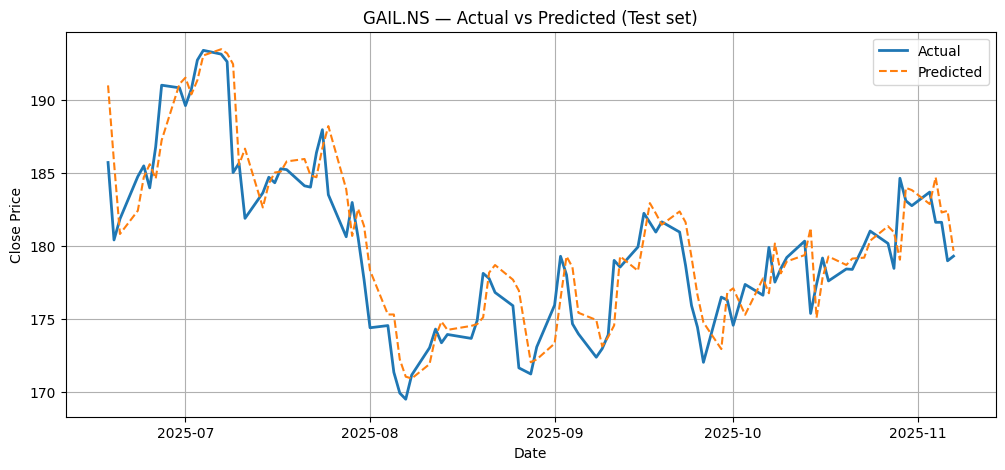

In [6]:
# Cell 7
y_pred_test = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
rmse_val = rmse(y_test, y_pred_test)
mae_val = mean_absolute_error(y_test, y_pred_test)
mape_val = mape(y_test, y_pred_test)   # fraction
close_acc = closeness_accuracy(y_test, y_pred_test)


print("Test set performance:")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"MAPE: {mape_val*100:.2f}%")
print(f"Closeness Accuracy: {close_acc:.2f}%")

# Plot actual vs predicted over the test period
plot_actual_vs_predicted(dates_test, y_test, y_pred_test,
                         title=f"{TICKER} — Actual vs Predicted (Test set)")


In [7]:
# Cell 9
# Prepare inputs for predicting today and tomorrow

# 1) Predict today's close: use the row before the last available row as lag features,
#    then we predict the close for the last available row's date (if that date's close is unknown this is useful).
if len(df) < 2:
    raise ValueError("Not enough data to form lag features for today/tomorrow prediction.")

# For consistency, create helper to build a single-row features array from a row (Series)
def build_features_from_row(row):
    return np.array([
        row['Open'],
        row['High'],
        row['Low'],
        row['Close'],
        row['Volume']
    ]).reshape(1, -1)

# To predict the close for the last_date in df using the previous day's values:
prev_day = df.iloc[-2]  # one before last = yesterday (if last is today)
features_for_today = build_features_from_row(prev_day)

predicted_close_today = pipeline.predict(features_for_today)[0]

# To predict tomorrow's close, use the last available day's OHLCV (the most recent row)
last_day = df.iloc[-1]
features_for_tomorrow = build_features_from_row(last_day)
predicted_close_tomorrow = pipeline.predict(features_for_tomorrow)[0]

print(f"Based on available data up to {df.index[-1].date()}:")
print(f"Predicted CLOSE for date {df.index[-1].date()} (today's close prediction using previous day features): {predicted_close_today:.2f}")
print(f"Predicted CLOSE for date {df.index[-1].date() + pd.Timedelta(days=1)} (tomorrow): {predicted_close_tomorrow:.2f}")


Based on available data up to 2025-11-07:
Predicted CLOSE for date 2025-11-07 (today's close prediction using previous day features): 179.67
Predicted CLOSE for date 2025-11-08 (tomorrow): 179.91


In [8]:
# Cell 10 (optional)
import joblib
joblib.dump(pipeline, f"{TICKER}_linreg_pipeline.pkl")
print("Saved pipeline to disk.")


Saved pipeline to disk.
